## **Twitter Sentiment Analysis** 
## **Usecase: PiggyVest**

### Overview
This notebook extracts and analyzes sentiment in tweets about PiggyVest using Natural Language Processing. The analysis involves data preprocessing, sentiment analysis using Huggingface pre-trained roBERTa model, which is well-suited for processing and interpreting sentiments in social media texts involving sarcasms and humors. The notebook is structured as follows:
1. Data Import and Initial Inspection
2. Data Preprocessing
3. Sentiment Analysis
4. EDA

In [1]:
# import librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import ipywidgets as widgets
from IPython.display import display
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
# import snowflake.connector
# import getpass

import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('en_core_web_lg')

### **DATA IMPORT AND INITIAL INSPECTION**
Let's start by collecting our data from the Snowflake warehouse, then understanding the structure and size of the dataset. We'll look at the first few rows and check the dimensions to get an idea of what we're working with.


In [ ]:
# Prompt for to enter secrets securely
user = getpass.getpass(prompt='Enter your Snowflake username: ')
password = getpass.getpass(prompt='Enter your Snowflake password: ')

In [2]:
# Establish the connection using the masked password
ctx = snowflake.connector.connect(
    user=user,
    password=password,
    account='hi37226.eu-north-1.aws',
    warehouse='sentiment_warehouse',
    database='sentiment_database',
    schema='sentiment_schema'
)

In [ ]:
# Create a cursor object
cur = ctx.cursor()

In [ ]:
# Execute a query
cur.execute("SELECT * FROM sentiment_database.sentiment_schema.dim_tweets")

In [154]:
# Fetch and print the result
tweets = cur.fetch_pandas_all()
data = tweets.copy()

In [3]:
tweets = pd.read_csv(r"..\data\processed\users_tweet\2024-08-26 2_18am.csv")
data = tweets.copy()

In [4]:
data.head()

,TWEET_ID,USER_ID,CREATED_AT,TEXT,URL,MENTIONS,LANG,FAVOURITES,RETWEETS,REPLIES,QUOTES,VIEW_COUNT,HASHTAGS
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN


In [5]:
data.shape

(1363, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TWEET_ID    1363 non-null   int64  
 1   USER_ID     1363 non-null   int64  
 2   CREATED_AT  1363 non-null   object 
 3   TEXT        1363 non-null   object 
 4   URL         590 non-null    object 
 5   MENTIONS    210 non-null    object 
 6   LANG        1363 non-null   object 
 7   FAVOURITES  1363 non-null   int64  
 8   RETWEETS    1363 non-null   int64  
 9   REPLIES     1363 non-null   int64  
 10  QUOTES      1363 non-null   int64  
 11  VIEW_COUNT  788 non-null    float64
 12  HASHTAGS    159 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 138.6+ KB


### **DATA CLEANING AND PREPROCESSING**
The columns with missing values will not be used within the scope of this notebook. In that case, we would not be handling the missing values

In [7]:
data.columns = data.columns.str.strip().str.lower()
data.columns

Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count',
       'hashtags'],
      dtype='object')

A `wordcount` column is created, and wordcounts < 2 will be dropped

In [8]:
data['wordcount'] = data.text.apply(lambda x: len(x.split(' ')))
data = data[data['wordcount'] >= 2].reset_index(drop=True)

In [9]:
print('Dataset shape:', data.shape)
print(data.columns)

Dataset shape: (1350, 14)
Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count', 'hashtags',
       'wordcount'],
      dtype='object')


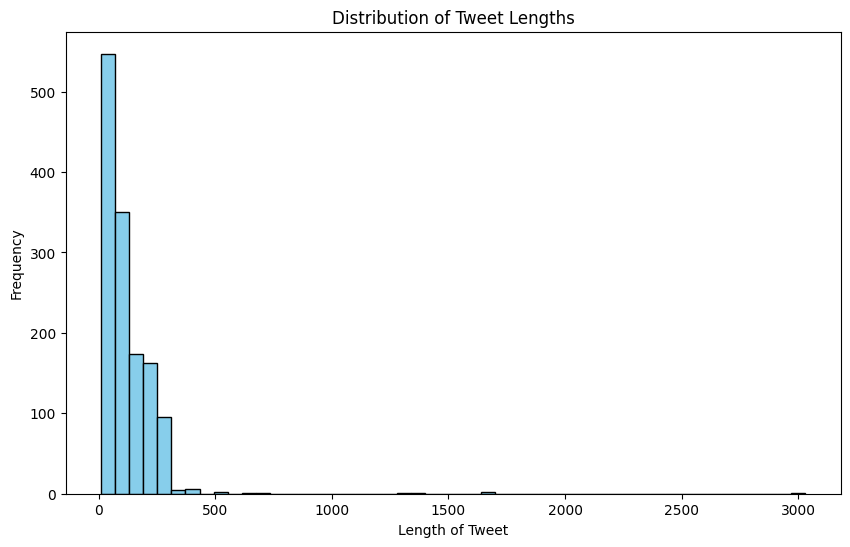

In [10]:
# Visualizing the distribution of tweet lengths
tweet_lengths = data['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

> More than 90% of the tweets have contain less than 500 characters, which is suitable for the model to handle

### **DATA PREPROCESSING**
Text data often contains noise such as special characters, links, and stopwords. This section outlines the preprocessing steps applied to clean the text data before sentiment analysis.

In [11]:
def preprocess(text):
    """
    Preprocesses the input text by removing special characters, stopwords and changes the characters  to lower case.
    
    Parameters:
    text (str): The raw tweet text.

    Returns:
    str: The cleaned, preprocessed text without punctuation nor stopwords.
    """
    lemmatizer = WordNetLemmatizer()
    preprocessed_text = []
    doc = nlp(text) 
    for i in doc:
        if i.is_punct:
            continue
        i = i.lemma_.lower()
        if i in stopwords.words('english'):
            continue
        preprocessed_text.append(i.lower())
        
    return ' '.join(preprocessed_text)
    

In [12]:
data['processed_text'] = data['text'].apply(preprocess)

### **SENTIMENT ANALYSIS**
We will use a Huggingface pre-trained transformer-based model `Roberta` to classify the sentiment of each tweet. The model is fine-tuned for sentiment analysis and will categorize tweets into positive, negative, or neutral sentiments.


In [13]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [14]:
model_path = r"C:\Users\HP\Documents\projects\Sentiment Analysis\model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at C:\Users\HP\Documents\projects\Sentiment Analysis\model were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def analyze(text, padding='max_length', max_length=514):    
    encode_text = tokenizer(text, return_tensors='pt')
    output = model(**encode_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]
    }
    max_key = max(scores_dict, key=scores_dict.get)
    
    return [max_key, max(scores_dict.values())]

#### **Sentiment Analysis on Cleaned Data**
Now, we'll analyze the sentiment of the preprocessed tweets. This analysis helps us understand the impact of data cleaning on sentiment classification.


In [31]:
cleaned_sentiment = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['processed_text']
        myid = row['tweet_id']
        cleaned_sentiment[myid] = analyze(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1350 [00:00<?, ?it/s]

In [35]:
cleaned_sentiment_df = pd.DataFrame([(key, value[0], value[1]) for key, value in cleaned_sentiment.items()], 
                  columns=['tweet_id', 'cleaned sentiment', 'confidence_score'])

In [36]:
cleaned_sentiment_df.head()

,tweet_id,cleaned sentiment,confidence_score
0,1819681803604508810,Neutral,0.521433
1,1819477474595545568,Neutral,0.517766
2,1819379501471535188,Neutral,0.755067
3,1819764467078508980,Negative,0.739657
4,1819440896863281310,Neutral,0.781369


In [37]:
cleaned_sentiment_df['cleaned sentiment'].value_counts()

Neutral     1005
Positive     208
Negative     137
Name: cleaned sentiment, dtype: int64

In [38]:
# merging the datasets into one

classified_tweets = data.merge(cleaned_sentiment_df, how='left')

The `created_at` column is changed from object to datatetime datatype

In [39]:
classified_tweets['date_created'] = pd.to_datetime(classified_tweets['created_at'])
classified_tweets.drop(columns='created_at', inplace=True)

In [40]:
positive = classified_tweets[classified_tweets['cleaned sentiment'] == 'Positive']
negative = classified_tweets[classified_tweets['cleaned sentiment'] == 'Negative']
neutral = classified_tweets[classified_tweets['cleaned sentiment'] == 'Neutral']

In [43]:
classified_tweets['confidence_score'] = classified_tweets['confidence_score'].round(2)

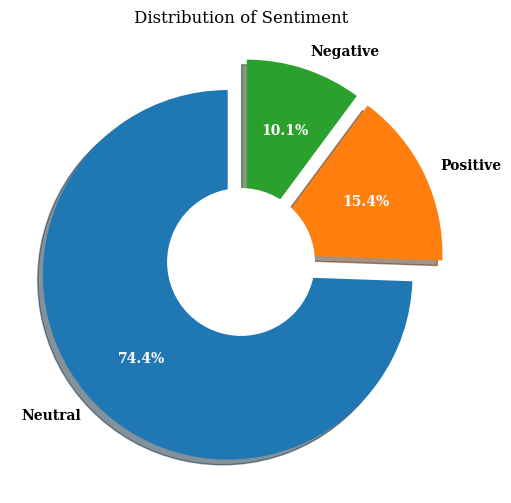

In [45]:
label_data = classified_tweets['cleaned sentiment'].value_counts()
explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribution of Sentiment')
plt.show()

## **EDA**

#### Analyzing the frequency of specific keywords

In [35]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [36]:
def most_common_chart(dataframe, title):
	corpus = ' '.join([i for i in dataframe.processed_text.values])
	tokenized_word = word_tokenize(corpus)
	count = FreqDist(tokenized_word)
	most_common = count.most_common(10)

	plt.figure(figsize=(10, 6))
	ax = sns.barplot(x=[word[1] for word in most_common], y=[word[0] for word in most_common])
	ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
	plt.xlabel('Frequency')
	plt.ylabel('Word')
	plt.title(title)
	print(most_common)
	plt.show()

[('piggyvest', 1297), ('money', 218), ('save', 217), ('use', 161), ('saving', 139), ('get', 134), ('go', 130), ('like', 106), ('dey', 91), ('piggyv', 90)]


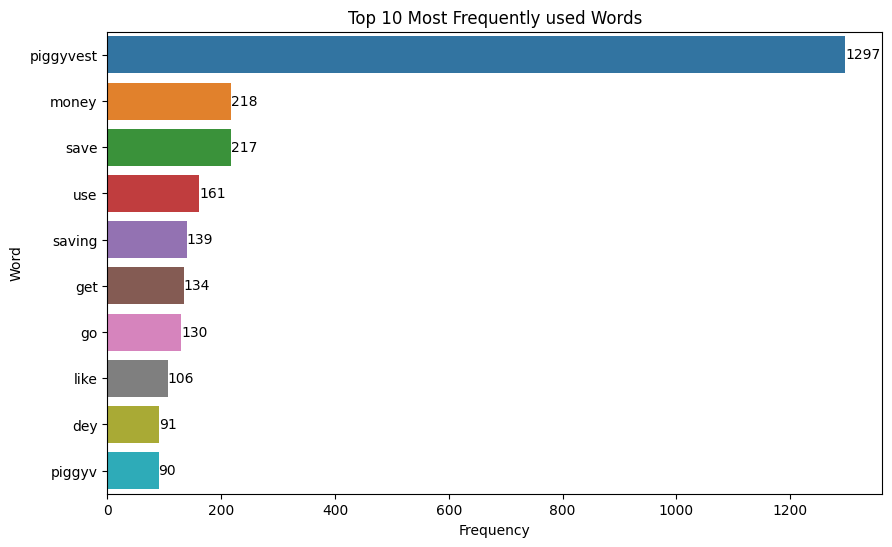

In [37]:
most_common_chart(classified_tweets, 'Top 10 Most Frequently used Words')

In [40]:
positive.head()

,tweet_id,user_id,created_at,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,wordcount,processed_text,cleaned sentiment


[('piggyvest', 208), ('save', 38), ('good', 36), ('use', 32), ('day', 29), ('saving', 28), ('get', 28), ('thank', 28), ('money', 26), ('year', 25)]


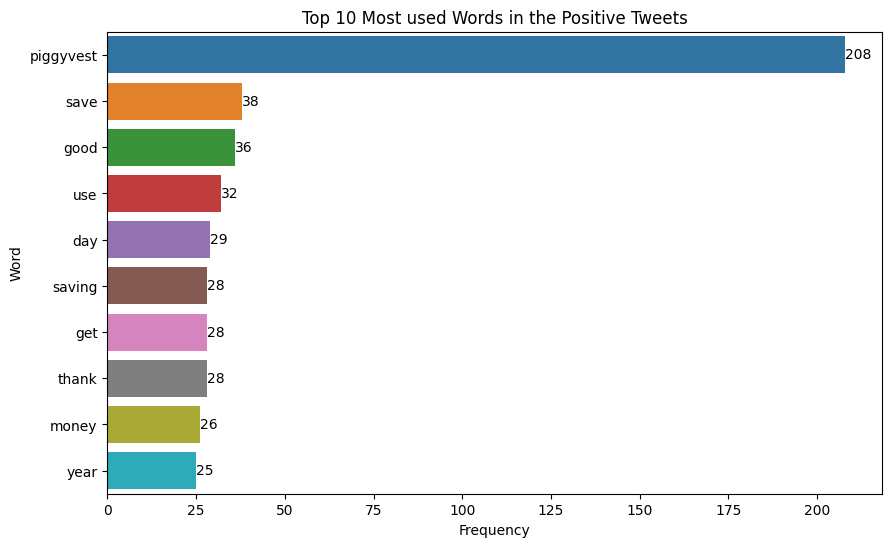

In [42]:
most_common_chart(positive, 'Top 10 Most used Words in the Positive Tweets')

[('piggyvest', 123), ('money', 35), ('go', 16), ('account', 15), ('people', 15), ('app', 14), ('say', 14), ('use', 14), ('save', 14), ('piggyv', 13)]


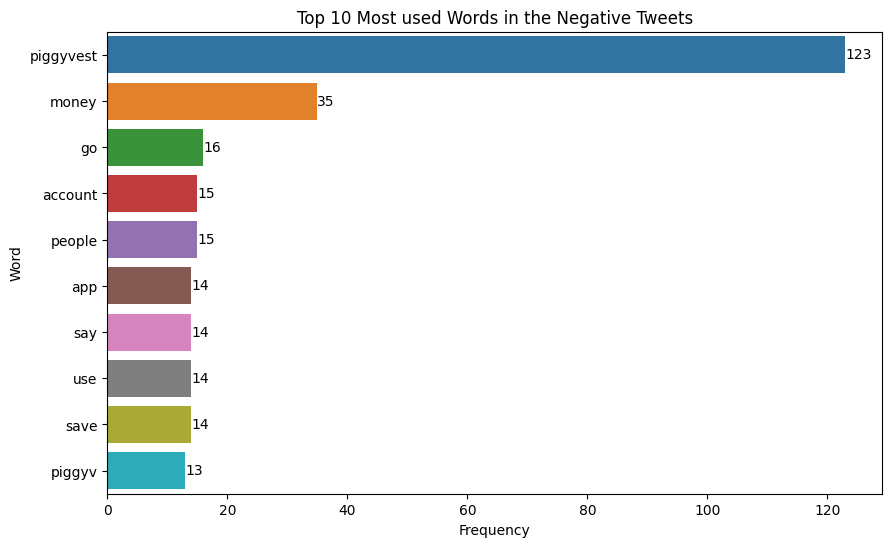

In [43]:
most_common_chart(negative, 'Top 10 Most used Words in the Negative Tweets')

#### Topic Modeling
Implementing the topic modeling technique, **Latent Dirichlet Allocation (LDA)** to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [50]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(data['processed_text'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
piggyvest dey save money use day na use piggyvest small piggyvest dey

Topic 1:
piggyvest money cowrywise cowrywise piggyvest want zenith lock help nigerians make

Topic 2:
piggyvest use save use piggyvest 000 saving invest start amp link

Topic 3:
piggyvest opay davido moses bliss moses bliss abraham toyin abraham toyin mercy

Topic 4:
piggyvest like open open piggyvest think app like piggyvest thank save trend

Topic 5:
piggyvest time investment platform saving try year save opay good

Topic 6:
piggyvest ibu mr ibu mr boys sportybet happie larry happie boys broke

Topic 7:
piggyvest money cowrywise piggyv piggyvest cowrywise app people account love make

Topic 8:
piggyvest account month saving buy piggyv dollar today bank like

Topic 9:
piggyvest money withdraw make thing user today year use break



<AxesSubplot:xlabel='cleaned sentiment', ylabel='wordcount'>

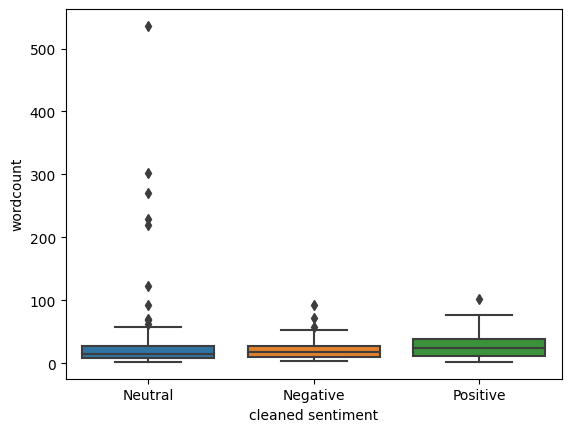

In [48]:
sns.boxplot(data=classified_tweets, x='cleaned sentiment', y='wordcount')

On an average, tweets with positive sentiment have more word counts compared to the other classes

In [55]:
tweets_by_month = classified_tweets.groupby(classified_tweets['date_created'].dt.to_period('M')).count()

positive_tweets_by_month = positive.groupby(positive['date_created'].dt.to_period('M')).count()
negative_tweets_by_month = negative.groupby(negative['date_created'].dt.to_period('M')).count()
neutral_tweets_by_month = neutral.groupby(neutral['date_created'].dt.to_period('M')).count()

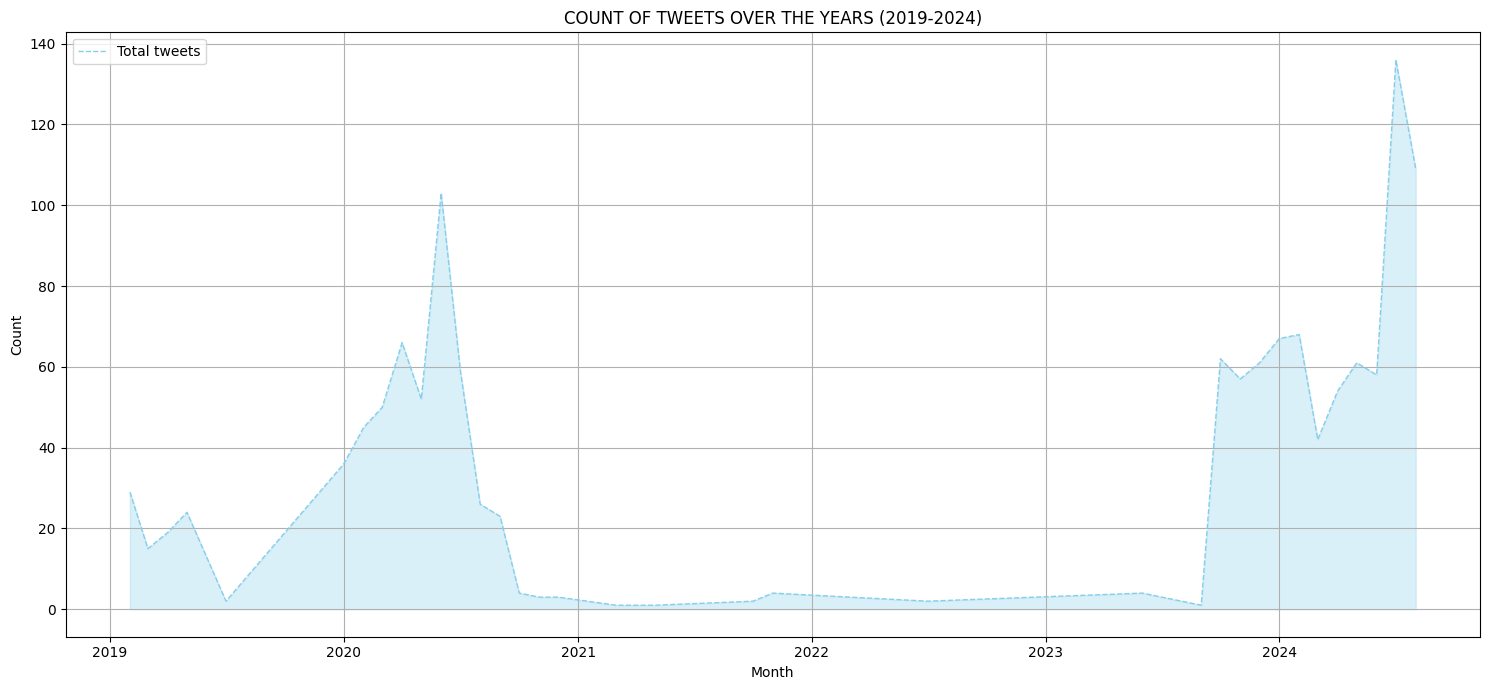

In [56]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(tweets_by_month.index.to_timestamp(), tweets_by_month['tweet_id'],linewidth=1, color='skyblue', linestyle='--', label='Total tweets')
plt.fill_between(tweets_by_month.index.to_timestamp(), tweets_by_month['tweet_id'], color='skyblue', alpha=0.3)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('COUNT OF TWEETS OVER THE YEARS (2019-2024)')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

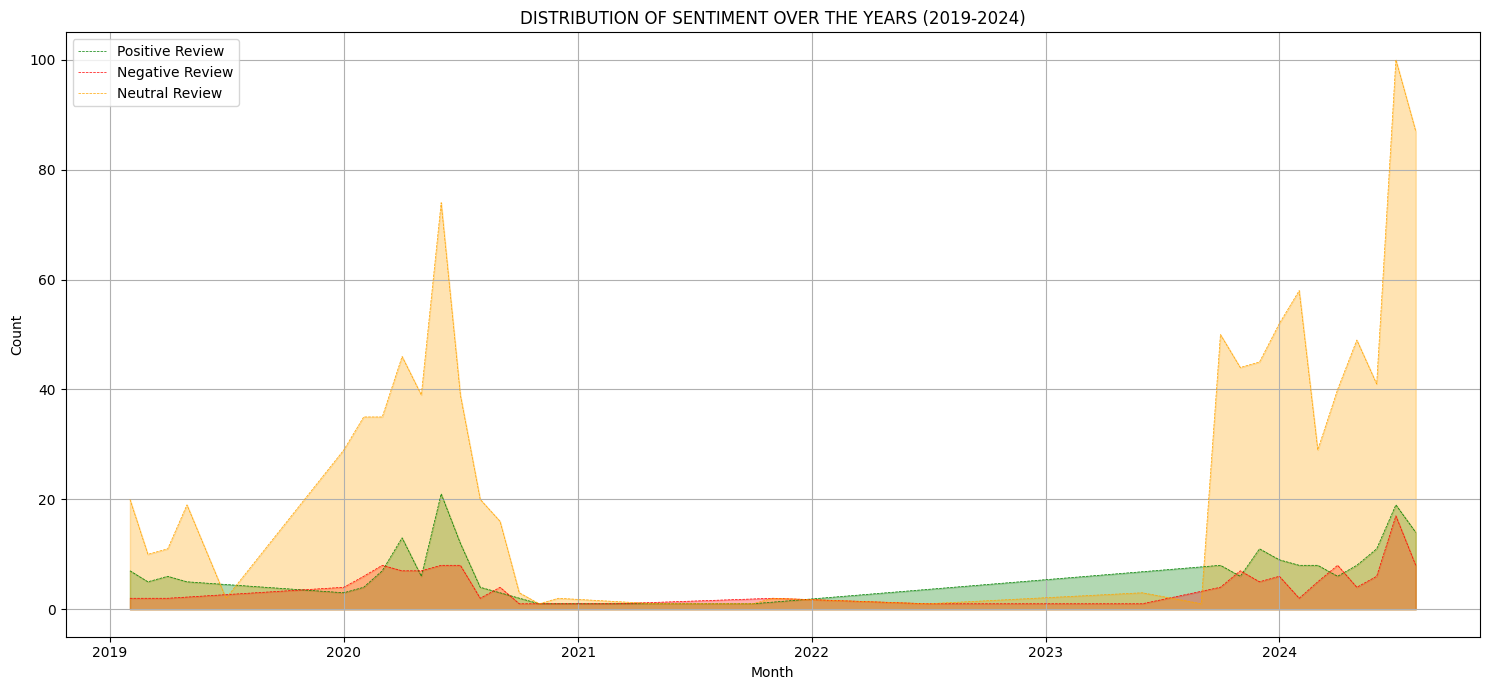

In [57]:
fig, ax = plt.subplots(figsize=(15, 7))

# Plot positive tweets line
plt.plot(positive_tweets_by_month.index.to_timestamp(), positive_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='green', label='Positive Review')
plt.fill_between(positive_tweets_by_month.index.to_timestamp(), positive_tweets_by_month['tweet_id'], color='green', alpha=0.3)

# Plot negative tweets line
plt.plot(negative_tweets_by_month.index.to_timestamp(), negative_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='red', label='Negative Review')
plt.fill_between(negative_tweets_by_month.index.to_timestamp(), negative_tweets_by_month['tweet_id'], color='red', alpha=0.3)

# Plot neutral tweets line
plt.plot(neutral_tweets_by_month.index.to_timestamp(), neutral_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='orange', label='Neutral Review')
plt.fill_between(neutral_tweets_by_month.index.to_timestamp(), neutral_tweets_by_month['tweet_id'], color='orange', alpha=0.3)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('DISTRIBUTION OF SENTIMENT OVER THE YEARS (2019-2024)')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

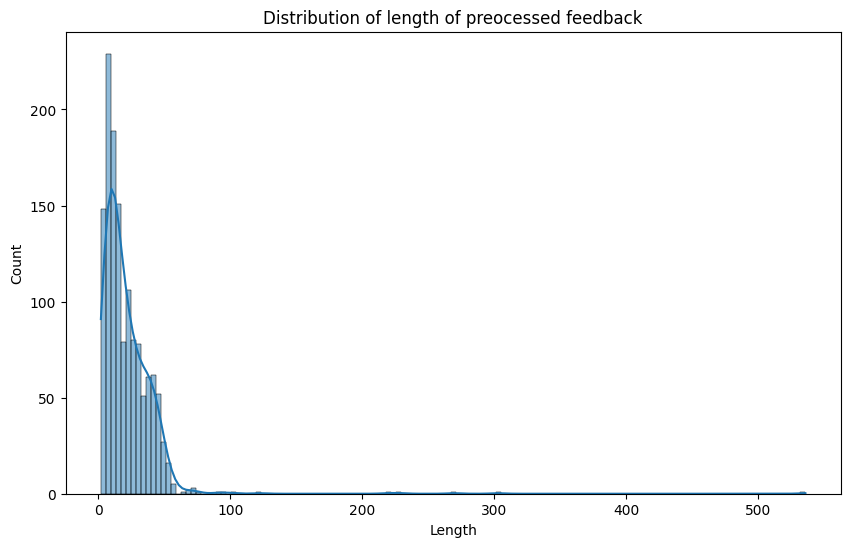

In [59]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(classified_tweets['wordcount'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

<AxesSubplot:>

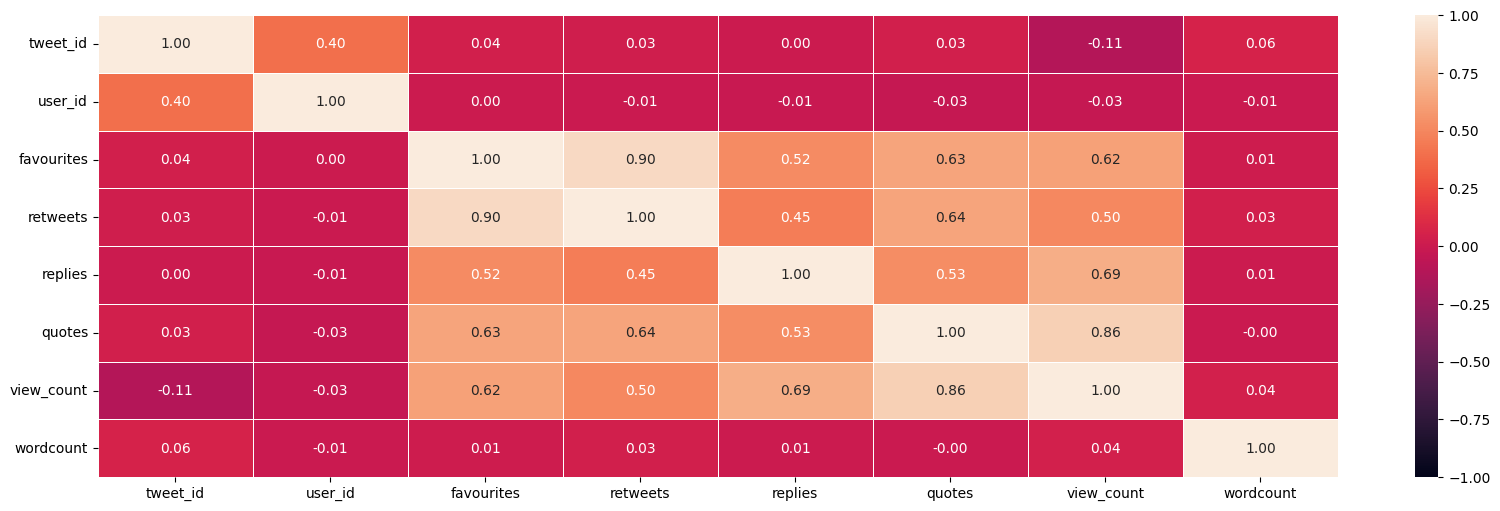

In [60]:
correlation_matrix = classified_tweets.corr()

plt.figure(figsize=[20, 6])
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)

### **OUTPUT DATASET**

The file is saved into the `/data/processed/users_tweet/` folder

In [46]:

csv_file_path = '../data/processed/users_tweet/data_robertaCS.csv'

# Save the DataFrame to the CSV file in the users_tweet folder
classified_tweets.to_csv(csv_file_path, index=False)

### **CONCLUSION**

This notebook is designed to extract and analyze the sentiment expressed in tweets about PiggyVest using Natural Language Processing (NLP) techniques. The analysis is carried out using NLTK's inbuilt VADER model, which is well-suited for processing and interpreting sentiments in social media texts. The notebook is organized into the following key sections:

Data Import and Initial Inspection: This section involves fetching raw tweet data from a Snowflake data warehouse. The data is then converted into a pandas DataFrame for ease of manipulation. Initial inspection of the data includes exploring its structure and content to ensure it is suitable for further analysis.

Data Cleaning and Preprocessing: This phase focuses on preparing the data for sentiment analysis. It includes feature engineering, where new columns may be created to enhance the dataset's utility. Data preprocessing steps involve removing irrelevant elements such as stopwords, punctuation, and special characters to clean the text data. This ensures that the sentiment analysis is based on meaningful and relevant text.

Sentiment Analysis: In this section, sentiment extraction is performed using using Huggingface pre-trained roBERTa model, which is well-suited for processing and interpreting sentiments in social media texts involving sarcasms and humors.

Exploratory Data Analysis (EDA): The final section involves performing exploratory data analysis to understand the distribution and patterns of sentiments among Twitter users. EDA provides insights into how sentiments are distributed, identifies trends, and helps in interpreting the overall sentiment landscape related to PiggyVest.

#### **`NOTE`**

A new dataset `data_robertaCS.csv` is created and saved in the `../data/processed/users_tweet/` directory. This dataset contains additional *'date_created'*,  *'processed_text'*, *'cleaned sentiment'* and *'confidence_score'* columns